This kernel follows the [paper](http://arxiv.org/abs/1609.07124) and the [blog](http://burakhimmetoglu.com/machine-learning-meets-quantum-mechanics/) both by Burak Himmetoglu.


Work in progress :)

In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
import time
start_time = time.time()

columbl
energy-molecule



> **1. Data understanding**

In [25]:
df = pd.read_csv('../input/energy-molecule/roboBohr.csv')

Size of dataset

In [26]:
print(df.shape)

(16242, 1278)


Columns in the dataset

* **Unnamed: 0** - Index for each molecule.
* **0-1274** - 1275 entries in the Coulomb matrix that act as molecular features.
* **pubchem_id** - Pubchem Id where the molecular structures are obtained. A unique identifier for each molecule
* **Eat** - atomization energy calculated by simulations using the Quantum Espresso package.

In [27]:
df.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '1267', '1268', '1269', '1270', '1271', '1272', '1273', '1274',
       'pubchem_id', 'Eat'],
      dtype='object', length=1278)

Checking for missing values

In [28]:
df.isnull().sum().sum()

0

In [29]:
df.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,pubchem_id,Eat
0,0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,12.365984,12.342823,12.335925,12.328055,12.284265,12.269844,12.247357,10.557967,10.473721,9.225262,8.448526,7.611145,7.610874,7.580510,7.579386,7.576929,7.536001,7.517317,7.462578,7.459865,7.456214,7.447581,7.443458,7.423496,7.345785,7.323741,7.247088,7.230886,6.662523,6.286251,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,25004,-19.013763
1,1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,15.227643,15.202985,14.800045,12.855629,12.728858,12.618058,12.589962,12.557323,12.074893,10.607138,10.572061,10.464293,9.816674,9.456914,9.455816,8.865704,8.104048,8.006855,7.968817,7.946644,7.932943,7.922656,7.888724,7.885692,7.783220,7.637477,7.636586,7.631457,7.336591,7.127698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25005,-10.161019
2,2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,8.698826,7.607776,7.550253,7.446675,7.398848,7.381532,7.355045,7.321944,6.625986,6.116315,6.106397,6.098066,5.989868,5.731750,5.700963,5.371527,5.008911,4.894453,4.826545,4.352232,4.270598,2.902330,2.902220,2.901834,2.901089,2.900168,2.900151,2.899983,2.898772,2.898551,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25006,-9.376619
3,3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,12.444141,12.420665,12.410312,12.346845,12.175480,12.098758,10.612802,10.610273,10.606738,10.606702,10.433290,8.694957,8.421582,8.103569,8.103345,7.595619,7.566897,7.555411,7.413109,7.403199,7.185256,6.915425,6.198245,6.191266,6.181797,6.152544,5.252689,5.244354,5.176740,5.176314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25009,-13.776438
4,4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,10.595914,10.485270,8.595823,8.103880,8.103567,7.975189,7.546413,7.503300,6.803380,6.738768,5.169492,5.161869,5.145972,4.924911,4.899245,4.534996,4.486310,3.897466,3.081523,2.957823,2.903069,2.902178,2.900610,2.900542,2.900306,2.899368,2.899113,2.897739,2.896793,2.896063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25011,-8.537140


Unique columns that can be dropped

In [30]:
df = df.drop(['Unnamed: 0', 'pubchem_id'], axis = 1)

Target Variable: **Eat**

In [31]:
df.Eat.describe()

count    16242.000000
mean       -11.178969
std          3.659133
min        -23.245373
25%        -13.475805
50%        -10.835211
75%         -8.623903
max         -0.789513
Name: Eat, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


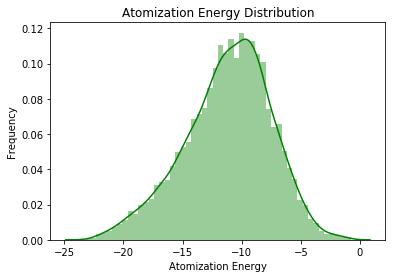

In [32]:
sns.distplot(df['Eat'], kde=True, color="g")
plt.xlabel('Atomization Energy')
plt.ylabel('Frequency')
plt.title('Atomization Energy Distribution');

> **2. Feature Extraction**

PCA

In [33]:
# data taken from https://github.com/bhimmetoglu/RoboBohr/tree/master/data
columbl = pd.read_csv('../input/columbl/coulombL.csv', header=None, index_col=0)

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
z = pca.fit_transform(columbl)
z = pd.DataFrame(z)

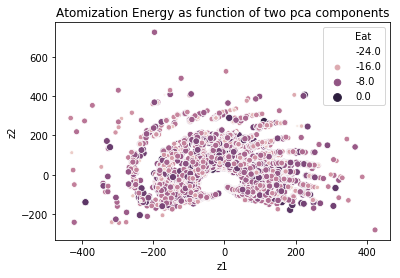

In [35]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
ax = sns.scatterplot(x=-z[0], y=z[1],
                     size=df.Eat,hue=df.Eat,
                     palette=cmap, sizes=(5, 60))
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Atomization Energy as function of two pca components');

Adding the PCA components to the dataset for modeling

In [36]:
#z.rename(columns={0:'pca_0', 1:'pca_1'}, inplace=True)
#df = pd.concat([df, z], axis=1, sort=False)

> **3. Modeling**

Here I decided to check different methods linear models, nearest neighbors and boosted trees. The [paper](https://arxiv.org/abs/1609.07124) stated that the best method is booosted trees used with xgboost. Let's check this out here. In addition to that I will present the results I got from stacking and averaging some of the models to get better outcomes. 

In [37]:
Y = df['Eat']
df = df.drop(['Eat'], axis = 1)


In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
x_train, x_test, y_train, y_test = train_test_split(df, Y, test_size=0.3)

Inspired from [this kernel](http://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from lightgbm.sklearn import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

lgbm_model = LGBMRegressor(num_leaves = 25, n_estimators = 250, min_child_weight = 5, max_depth = 4, learning_rate = 0.08,
                           colsample_bytree = 0.3)

xgb_model = XGBRegressor(objective='reg:linear', eval_metric = 'rmse', learning_rate = 0.0625, reg_lambda = 0,
                         max_depth = 6, colsample_bytree = 0.2, min_child_weight = 10, n_estimators = 400)
rf_model = RandomForestRegressor(n_estimators = 100, min_samples_split = 3, max_features = 'auto', max_depth = 8)
knn_model = KNeighborsRegressor(weights = 'distance', n_neighbors = 3, leaf_size = 90)
ridge_model = Ridge(alpha = 1000)
lasso_model = Lasso(alpha = 0.01, max_iter=10000)
enet_model = ElasticNet(alpha = 0.01, l1_ratio = 0.1, max_iter=10000)

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin


class AveragingRegressor(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, regressors):
        self.regressors = regressors
        self.predictions = None

    def fit(self, X, y):
        for regr in self.regressors:
            regr.fit(X, y)
        return self

    def predict(self, X):
        self.predictions = np.column_stack([regr.predict(X) for regr in self.regressors])
        return np.mean(self.predictions, axis=1)
    
    
averaged_model = AveragingRegressor([xgb_model, lgbm_model])

In [41]:
from mlxtend.regressor import StackingCVRegressor

stacked_model = StackingCVRegressor(
    regressors=[xgb_model, lgbm_model],
    meta_regressor=Ridge()
)

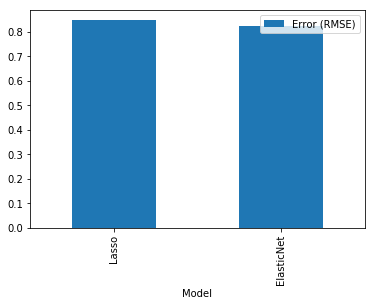

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def rmse_fun(predicted, actual):
    return np.sqrt(np.mean(np.square(predicted - actual)))

rmse = make_scorer(rmse_fun, greater_is_better=False)

models = [
     ('XGBoost', xgb_model),
     ('LightGBM', lgbm_model),
     ('RandomForest', rf_model),
     ('Ridge', ridge_model),
     ('Lasso', lasso_model),
     ('ElasticNet', enet_model),
     ('KNN', knn_model),
     ('Averaged', averaged_model),
     ('Stacked', stacked_model),
]

scores = [
    -1.0 * cross_val_score(model, x_train.values, y_train.values, scoring=rmse, cv=5).mean()
    for _,model in models
]

dataz = pd.DataFrame({ 'Model': [name for name, _ in models], 'Error (RMSE)': scores })
dataz.plot(x='Model', kind='bar')

In [43]:
dataz

,Model,Error (RMSE)
0,XGBoost,0.110048
1,LightGBM,0.114286
2,RandomForest,0.209331
3,Ridge,0.819103
4,Lasso,0.846127
5,ElasticNet,0.823435
6,KNN,0.687423
7,Averaged,0.104478
8,Stacked,0.104385


In [74]:
stacked_model.fit(x_train, y_train)
y_pred_stack = stacked_model.predict(x_test)
print("The score for stacked models (xgb + lgb) is "+str(np.sqrt(mean_squared_error(y_test, y_pred_stack))))

The score for stacked models (xgb + lgb) is 0.08509649574348609


In [75]:
averaged_model.fit(x_train, y_train)
y_pred_avg = averaged_model.predict(x_test)
print("The score for averaged models (xgb + lgb) is "+str(np.sqrt(mean_squared_error(y_test, y_pred_avg))))

The score for averaged models (xgb + lgb) is 0.08630398303741706


In [76]:
xgb_model.fit(x_train, y_train)
y_pred_xgb = xgb_model.predict(x_test)
print("The score for xgb model is "+str(np.sqrt(mean_squared_error(y_test, y_pred_xgb))))

The score for xgb model is 0.08715347273061655


In [58]:
print('Valid stacked mean: %.3f' % y_pred_stack.mean())
print('Valid avg mean: %.3f' % y_pred_avg.mean())
print('Valid xgb mean: %.3f' % y_pred_xgb.mean())

print('Test mean: %.3f' % y_test.mean())

Valid stack mean: -11.178
Valid avg mean: -11.179
Valid xgb mean: -11.180
Test mean: -11.178


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


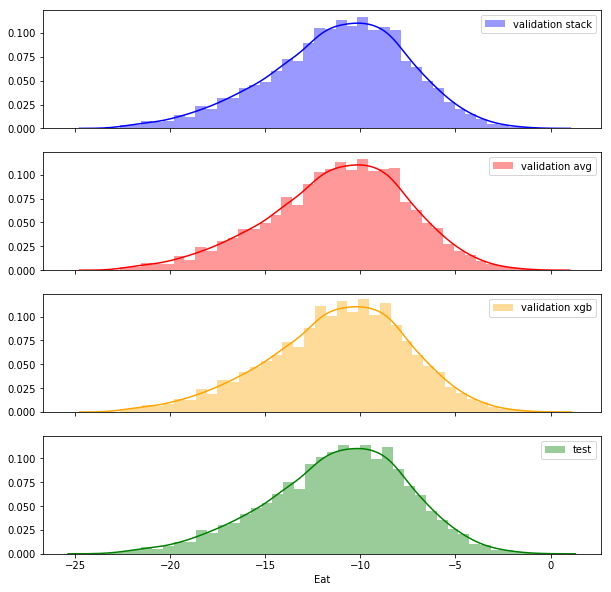

In [73]:
fig, ax = plt.subplots(nrows=4, sharex=True, sharey=True, figsize=(10,10))
sns.distplot(y_pred_stack, ax=ax[0], color='blue', label='validation stack')
sns.distplot(y_pred_avg, ax=ax[1], color='red', label='validation avg')
sns.distplot(y_pred_xgb, ax=ax[2], color='orange', label='validation xgb')
sns.distplot(y_test, ax=ax[3], color='green', label='test')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
ax[2].legend(loc=0)
ax[3].legend(loc=0)
plt.show()

In [61]:
print(" Seconds %0.3f" % (time.time() - start_time))

 Seconds 2433.306
